# Inteligencia artificial embebida

## Clasificación de eventos masticatorios

---
$IAE$ @ LSE, FI-UBA : 2022

## Introducción al problema

El sector ganadero está en continua búsqueda de tecnologías que permitan aumentar la productividad y los márgenes de la actividad. Un área específica dentro de la ganadería es el monitoreo alimentario, que permite un control de la salud y bienestar de los animales. También constituye una herramienta para la selección de los genes más aptos. Mediante el análisis y caracterización de los sonidos que los animales producen al comer es posible estimar la cantidad de alimento ingerido durante el pastoreo, brindando un mayor control sobre la alimentación de cada animal en un rodeo.

Los rumiantes, como las ovejas o las vacas, presentan tres tipos de movimientos mandibulares característicos durante el pastoreo:

- **Masticación** (o *chew*, del inglés): Consiste en el triturado del alimento ingerido. El animal utiliza las piezas dentarias posteriores. Se da durante la rumia y el pastoreo.
- **Arranque** (o *bite*, del inglés): Consiste en el corte y rasgado de la pastura. El animal utiliza las piezas dentarias anteriores. Se da únicamente en el pastoreo.
- **Arranque-masticación** (o *chew-bite*, del inglés): Es un solo movimiento que consiste en la combinación de los dos anteriores. Se da únicamente en el pastoreo.

![image.png](attachment:49066c0d-7691-49b6-9456-65ff1a1c295b.png)

#### Objetivo
Cada uno de estos movimientos generan un sonido particular, que puede ser grabado mediante un micrófono ubicado en la frente del animal. 
El **objetivo planteado en este problema** es identificar el tipo de evento masticatorio a partir de estas grabaciones.

![image.png](attachment:ce59d621-cf89-4b36-b635-776faafe81ed.png)

## Sobre el conjunto de datos

#### Grabaciones (`data.zip`):

El conjunto de datos está compuesto por grabaciones (WAV) de un corpus perteneciente al sinc(i) (UNL-CONICET) y a la Facultad de Ciencias Agrarias de la UNR, especialmente etiquetados para la [competencia desarrollada](https://metadata.fundacionsadosky.org.ar/competition/14/) en el marco de las [Jornadas de Inteligencia Artificial del Litoral](http://sinc.unl.edu.ar/ia-litoral/) en el 2019. Cada grabación tiene una duración fija de 800 ms y corresponde a uno de los eventos masticatorios descriptos anteriormente.

#### Etiquetas de entrenamiento (`train_label.csv`):

Las etiquetas están organizadas en un archivo csv, donde cada número corresponde a una categoría diferente:
- 0: bite
- 1: chew
- 2: chew-bite

Además, cada grabación del conjunto de entrenamiento tiene anotadas las características de la pastura que se estaba consumiendo:
- pasture: tipo de pastura (alfalfa / fescue)
- height: altura de la pastura al momento de la grabación ( short / tall )

#### Evaluación (`test_files.csv`)

La métrica que se usará para evaluar será el **balanced accuracy** (promedio de recall por clase) considerando las etiquetas del conjunto privado de prueba.
Las respuestas de los participantes deberán ser archivos .csv con columnas grabación y etiqueta.

    0001,0
    0002,1
    0003,1
    0004,0
    0005,2

donde grabación será el nombre del archivo wav (sin “.wav”) y etiqueta corresponde a la categoría predicha por el modelo.

## Preparación del entorno

En el caso de que la librería no esté disponible en el entorno virtual, se puede instalar agregando la línea:

    !pip install librosa

Cualquier línea que comience con un signo de exclamación será ejecutada por el sistema. De forma similar, también podría instalarse alguna versión particular de una librería:
    
    !pip install librosa==0.8.1
    
Comenzamos importando las librerías necesarias. 

In [1]:
import os
from collections import namedtuple  # Tuplas con nombres (más fácil para acceder a los datos)

import numpy as np  # Cálculo matricial y vectorial
import matplotlib.pyplot as plt  # Graficación
import pandas as pd  # Manejo de hojas de cálculo
import zipfile  # Manejo de archivos ZIP
import scipy.io.wavfile  # Lectura/Escritura de archivos WAV
import scipy.signal  # Procesamiento de señales

from sklearn import set_config  # Parámetros para mostrar los pipelines de sklearn
set_config(display='diagram')

In [2]:
eventos = {0:'bite',
           1:'chew',
           2:'chew-bite'}

## Descarga de los datos de la competencia
Se crea una carpeta dónde descargar los archivos de la competencia.

Paso 1) Crear una nueva carpeta (si no existe ya)

In [3]:
main_folder = "SonidosMasticatorios"
if os.path.split(os.getcwd())[1] != main_folder:
    if not os.path.exists(main_folder):
        os.makedirs(main_folder)
    os.chdir(main_folder)

Paso 2) Descargar los archivos desde Dropbox con wget. En caso de existir, con la opción "no-clobber" evitamos que se vuelvan a descargar. Si los comandos siguientes no funcionan, se pueden descargar desde un navegador y colocar en la carpeta correspondiente.

In [4]:
!wget --quiet --no-clobber https://www.dropbox.com/s/d12x5vknrk9yek1/data.zip
!wget --quiet --no-clobber https://www.dropbox.com/s/qoyduoa5prupyzr/test_files.csv
!wget --quiet --no-clobber https://www.dropbox.com/s/z1cwznln0gfpw32/train_labels.csv

Paso 3) Descomprimir el archivo con los audios.

In [5]:
if not os.path.exists("./data") and os.path.isfile("data.zip"):
    with zipfile.ZipFile('data.zip', 'r') as zip_ref:
        zip_ref.extractall('.')

## Lectura de los archivos wav

Se crea una clase para manejar el dataset de forma más cómoda en las próximas etapas. Esta clase permite instanciar el dataset de train o test, realizar un cache a medida que lee los datos desde archivo y acceder a cada audio mediante el operador corchete.

In [6]:
WaveData = namedtuple("WaveData", ["data", "sample_freq", "label"])

class WaveDataset():
    
    #====================================================================
    def __init__(self, data_folder, annotation_file):
        """Construye un dataset desde carpeta de wav y csv de labels."""
        # Carpeta donde estan los wav
        self.data_folder = data_folder 
        
        # Crea una lista de nombres y etiquetas a partir del csv
        ds = pd.read_csv(annotation_file)
        self.filenames = list(ds['filename'])
        
        if 'label' in ds.columns:
            # Si existe una columna de labels la toma del csv
            self.labels = ds['label'].values
        else:
            # Caso contrario, los labels son todos -1
            self.labels = -np.ones(len(self.filenames))
            
        self.cache = {}
    
    #====================================================================
    def __len__(self):
        """Cantidad de patrones en el dataset."""
        return len(self.labels)
    
    #====================================================================
    def __getitem__(self, index):
        """Retorna la tupla (data, fs, label) en la posicion index."""
        if index in self.cache:
            data, fs, label = self.cache[index]
        else:
            # Lee el archivo wav y guarda (muestras, label) en cache
            fname = f"{self.filenames[index] :04d}.wav"
            fpath = os.path.join(self.data_folder, fname)
            
            fs, data = scipy.io.wavfile.read(fpath) # lectura de wavs con scipy
            data = data / np.iinfo(data.dtype).max  # Reescala entre -1 y 1
            
            # data, fs = librosa.load(fpath)  # lectura de wavs con librosa
            
            label = self.labels[index]
            self.cache[index] = (data, fs, label)
            
        return WaveData(data, fs, label)

## Exploración de los datos

Forma de onda para algunos ejemplos de cada tipo de evento a detectar

[-0.01818903 -0.01812799 -0.01803644 ... -0.00930815 -0.00952177
 -0.0105594 ] 0
[ 0.00146489  0.00119022  0.00158696 ... -0.01211585 -0.01242103
 -0.01275674] 2
[ 0.00598163  0.00631733  0.00646992 ... -0.00766015 -0.00738548
 -0.00686666] 1


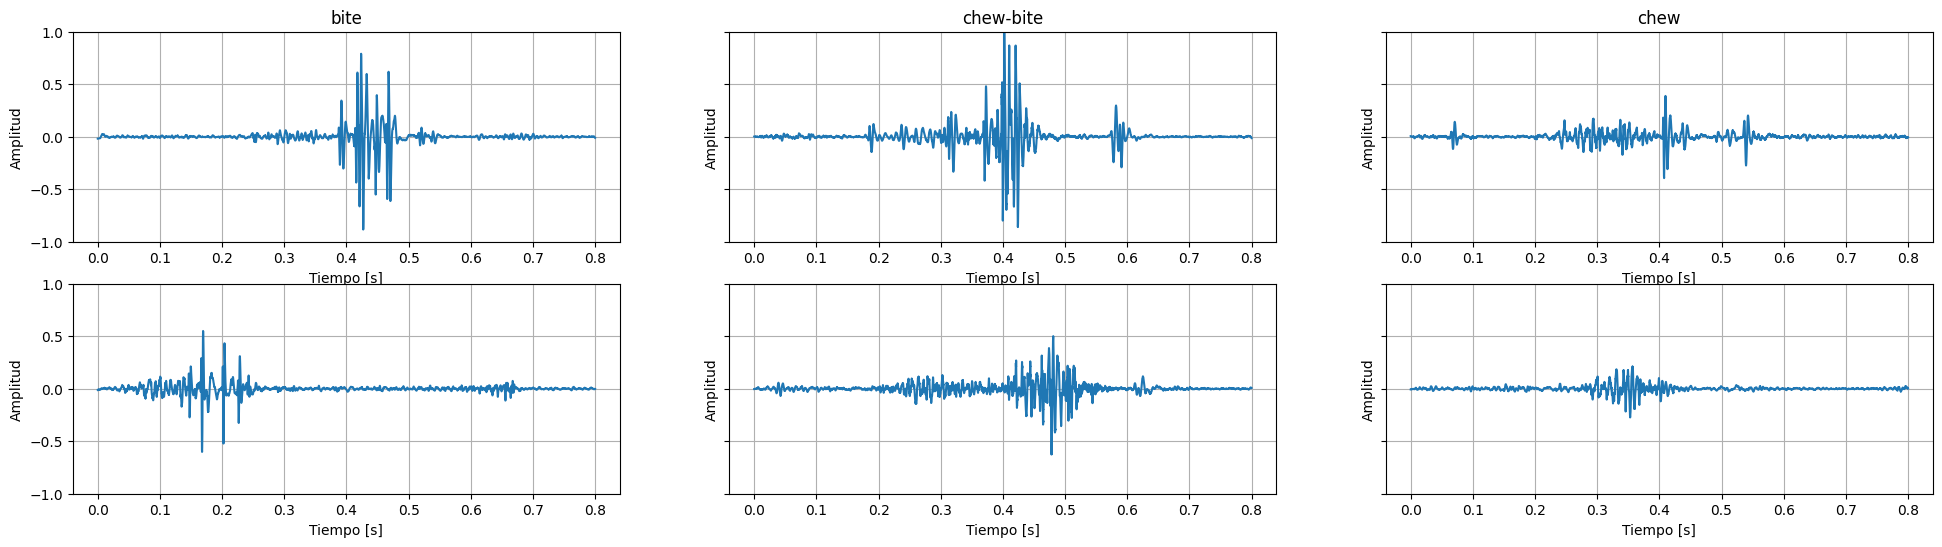

In [7]:
train_dataset = WaveDataset("./data/", "train_labels.csv")

t = np.arange(0,len(train_dataset[24].data)/train_dataset[24].sample_freq, 1/train_dataset[24].sample_freq)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24,6), sharey=True)
axes[0, 0].set_ylim((-1, 1))
axes[0, 1].set_ylim((-1, 1))

axes[0, 0].set_title("bite")
axes[0, 0].plot(t, train_dataset[24].data)
axes[0, 0].set_xlabel('Tiempo [s]')
axes[0, 0].set_ylabel('Amplitud')
axes[0, 0].grid(True)
print(train_dataset[24].data, train_dataset[24].label)

axes[1, 0].plot(t, train_dataset[48].data)
axes[1, 0].set_xlabel('Tiempo [s]')
axes[1, 0].set_ylabel('Amplitud')
axes[1, 0].grid(True)

axes[0, 1].set_title("chew-bite")
axes[0, 1].plot(t, train_dataset[0].data)
axes[0, 1].set_xlabel('Tiempo [s]')
axes[0, 1].set_ylabel('Amplitud')
axes[0, 1].grid(True)
print(train_dataset[0].data, train_dataset[0].label)

axes[1, 1].plot(t, train_dataset[1].data)
axes[1, 1].set_xlabel('Tiempo [s]')
axes[1, 1].set_ylabel('Amplitud')
axes[1, 1].grid(True)

axes[0, 2].set_title("chew")
axes[0, 2].plot(t, train_dataset[2].data)
axes[0, 2].set_xlabel('Tiempo [s]')
axes[0, 2].set_ylabel('Amplitud')
axes[0, 2].grid(True)
print(train_dataset[2].data, train_dataset[2].label)

axes[1, 2].plot(t, train_dataset[8].data);
axes[1, 2].set_xlabel('Tiempo [s]')
axes[1, 2].set_ylabel('Amplitud')
axes[1, 2].grid(True);

### Breve análisis de patrones por clase

In [8]:
train_dataset.labels

#[eventos[i] for i in train_dataset.labels]  # etiquetas con el nombre del evento masticatorio

array([2, 2, 1, ..., 1, 1, 0])

In [9]:
# Extraemos número de etiquetas únicas
labels, n_examples = np.unique(train_dataset.labels, return_counts=True)

print(labels, n_examples)

[0 1 2] [255 827 450]


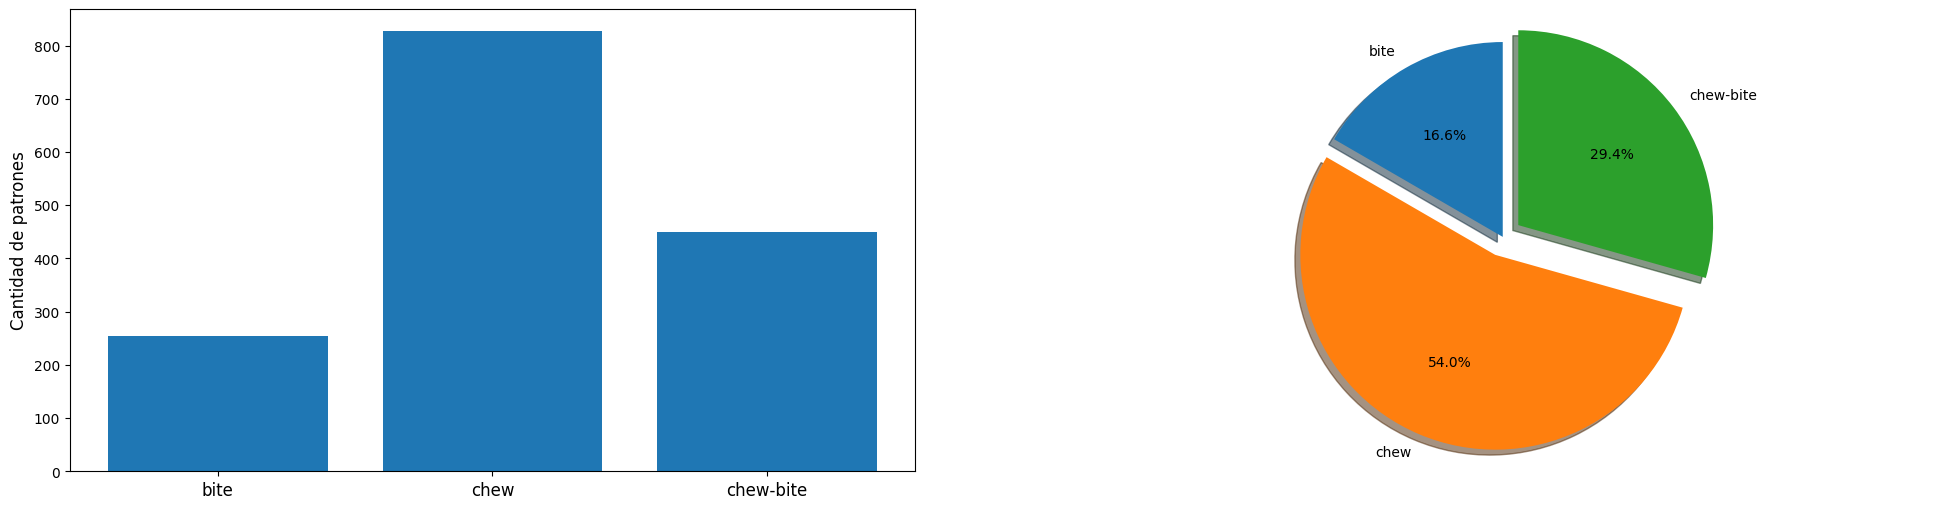

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(24,6))

ax[0].hist(train_dataset.labels, bins=[-.5, .5, 1.5, 2.5], rwidth=0.8)
ax[0].set_ylabel("Cantidad de patrones", fontsize=12)
ax[0].xaxis.set_ticks([0, 1, 2])
ax[0].xaxis.set_ticklabels([eventos[l] for l in labels], fontsize=12)

ax[1].pie(n_examples,
          explode=(0, 0.1, 0.1),  # only "explode" the 2nd slice (i.e. 'Hogs'),
          labels=[eventos[l] for l in labels],
          autopct='%1.1f%%',
          shadow=True,
          startangle=90)

ax[1].axis('equal');  # Equal aspect ratio ensures that pie is drawn as a circle.

## Extracción de características

Se definen funciones para procesar las señales de audio y extraer las características que verá el clasificador. En este problema este procesamiento y extracción de características será un paso previo a construir la matriz con los patrones que verá el clasificador.

### Preprocesamiento

Calcula la envolvente y la señal de audio rectificada a partir de la señal sonora.

In [11]:
def preprocessing(raw_signal, sample_freq):

    # Rectification 
    rectified_signal = np.abs(raw_signal)

    # Low-pass filtering -> envelope
    cutoff_freq = 5  # Hz
    sos_butter = scipy.signal.butter(2, cutoff_freq, 'lowpass', output="sos", fs=sample_freq)
    envelope = scipy.signal.sosfiltfilt(sos_butter, rectified_signal, axis=0)

    return envelope, rectified_signal


### Características

Se procesa la señal temporal para extraer cuatro características: la duración del evento, los cambios de signos de la pendiente de la envolvente, la amplitud máxima y un indicador de la simetría del evento.

In [12]:
def extract_features(raw_signal, sample_freq, plot_features=False):
    
    envelope, rectified_signal = preprocessing(raw_signal, sample_freq)
     
    threshold = 0.0230  # umbral para duracion y signo de la pendiente de la envolvente
    above_thres = envelope >= threshold  # arreglo booleano para restringir zona de calculo
    
    # variables y señales auxiliares
    max_pos = np.argmax(envelope)  # posicion del maximo en la ventana
    
    # al multiplicar por above_thres hace cero por debajo del umbral (enmascara)
    envelope_slope_sign = np.sign(np.diff(envelope, append=0)) * above_thres
    duration_signal = np.ones(envelope.shape) * above_thres  

    # Caracteristicas
    duration = np.sum(duration_signal) / sample_freq
    zero_crossing = np.count_nonzero(np.abs(np.diff(envelope_slope_sign)))
    amplitude = np.max(rectified_signal)
    ratio = np.trapz(envelope[:max_pos], axis=0) / np.trapz(envelope, axis=0)
    std = np.std(raw_signal)

    features = [duration, zero_crossing, amplitude, ratio, std]  
        
    # Grafica las caracteristicas
    if plot_features:
        
        t = np.arange(0, len(raw_signal)/sample_freq, 1/sample_freq)
        
        fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(24,12), sharex=True)
        axes[0].plot(t, raw_signal)
        axes[0].set_title("Señal sonora")
        axes[0].grid(True)
        
        axes[1].plot(t, envelope)
        axes[1].set_title("Envolvente")
        axes[1].plot([0, t.max()], [threshold, threshold], "--")
        axes[1].legend(["Envolvente", "Umbral"])
        axes[1].grid(True)
        
        axes[2].plot(t, envelope_slope_sign)
        axes[2].set_title("Signo de la pendiente de la envolvente")
        axes[2].grid(True)
        
        axes[3].plot(t, duration_signal)
        axes[3].set_title("Duración")
        axes[3].set_xlabel("Tiempo [s]")
        axes[3].grid(True)
        
        fig.tight_layout()
        plt.show()
        
        print(["Duración (s)", "Cruces por cero", "Amplitud máxima", "Simetria", "Desvio"])
        print(features)
    
    return features

### Ilustración de las características extraídas

In [13]:
n = 2
print(eventos[train_dataset[n].label])
features = extract_features(train_dataset[n].data, train_dataset[n].sample_freq)




print(features)

chew
[0.3473469387755102, 7, 0.39420758690145574, 0.5745041270194682, 0.046092456313828016]


### Construcción de la matriz de patrones y etiquetas de entrenamiento

In [14]:
X_train = np.vstack([extract_features(wavdata.data, wavdata.sample_freq) for wavdata in train_dataset])
X_train

array([[0.38698413, 6.        , 1.        , 0.55813294, 0.10895541],
       [0.36195011, 5.        , 0.62663656, 0.62925892, 0.0657933 ],
       [0.34734694, 7.        , 0.39420759, 0.57450413, 0.04609246],
       ...,
       [0.20575964, 3.        , 0.19531846, 0.58667954, 0.03249648],
       [0.1860771 , 3.        , 0.1609241 , 0.5903956 , 0.02630938],
       [0.58045351, 8.        , 0.49534593, 0.31810936, 0.06667547]])

In [15]:
# Features numéricas
y_train = np.array([wavdata.label for wavdata in train_dataset])

# Features tipo "string"
#y_train = [eventos[wavdata.label] for wavdata in train_dataset]

#print(y_train)

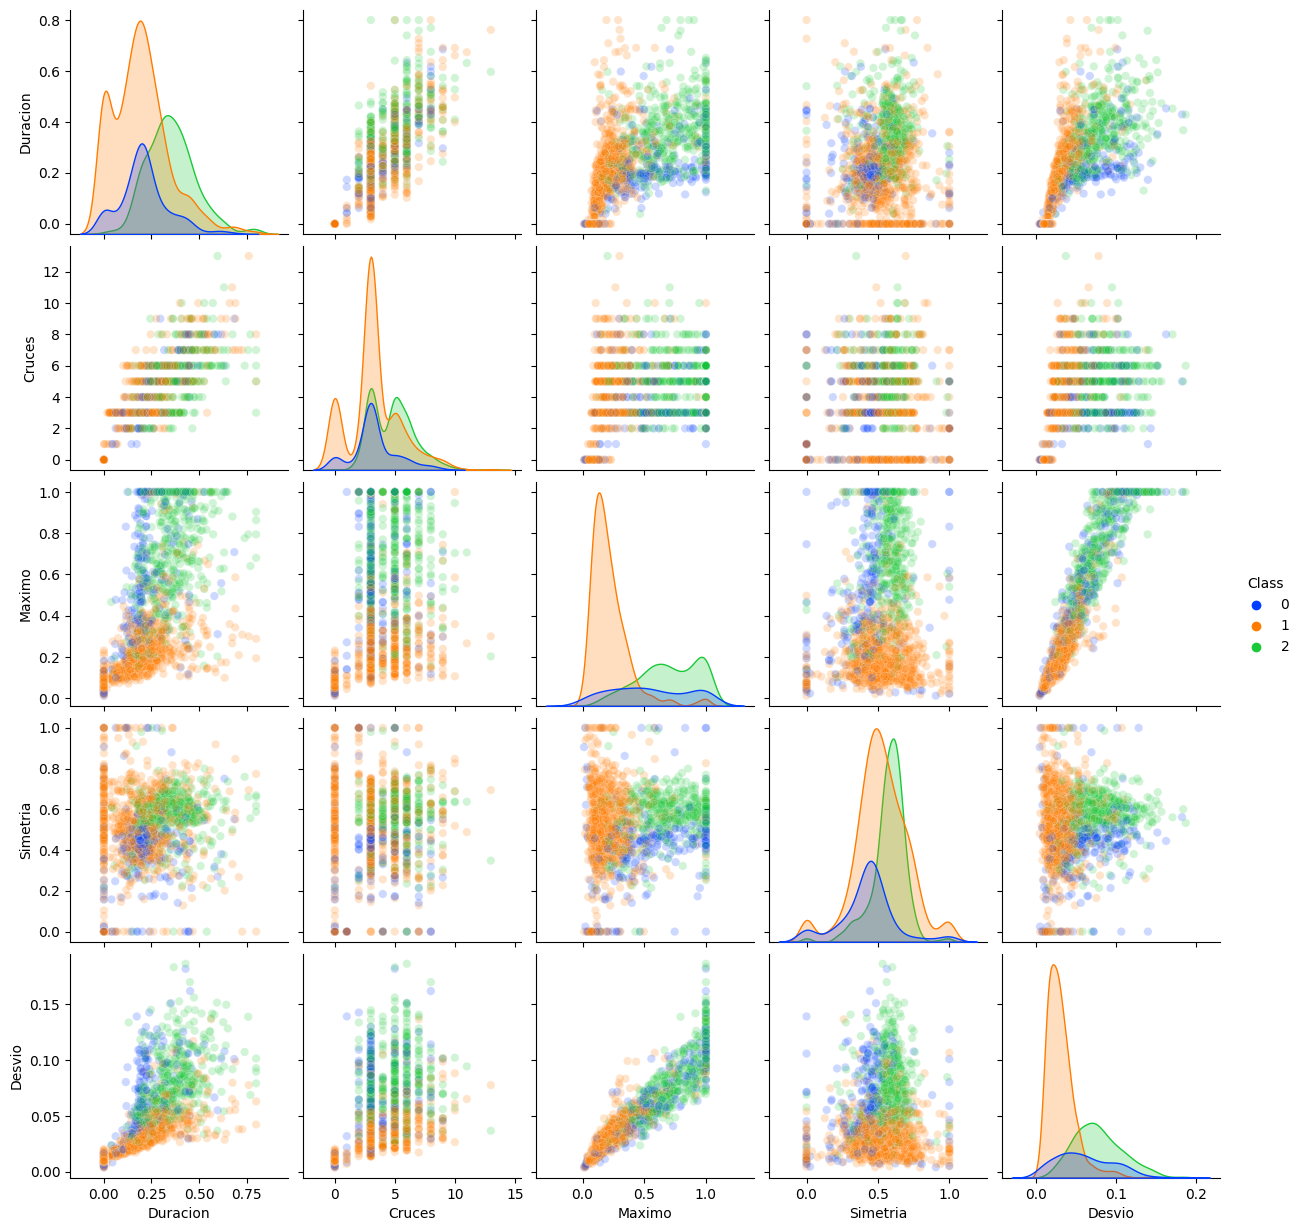

In [16]:
import pandas.testing as tm
import seaborn

colnames = ["Duracion", "Cruces", "Maximo", "Simetria", "Desvio"]

df_train = pd.DataFrame(X_train, columns=colnames)
df_train.insert(len(df_train.columns), "Class", y_train)

seaborn.pairplot(df_train,
                 vars=colnames,
                 hue="Class",
                 plot_kws={'alpha':0.2},
                 palette="bright");

In [17]:
df_train

,Duracion,Cruces,Maximo,Simetria,Desvio,Class
0,0.386984,6.0,1.000000,0.558133,0.108955,2
1,0.361950,5.0,0.626637,0.629259,0.065793,2
2,0.347347,7.0,0.394208,0.574504,0.046092,1
3,0.475828,7.0,0.919919,0.536349,0.112332,2
4,0.461950,9.0,0.664846,0.635280,0.069970,2
...,...,...,...,...,...,...
1527,0.256463,3.0,0.329325,0.661445,0.042843,1
1528,0.242313,3.0,0.311594,0.653968,0.042141,1
1529,0.205760,3.0,0.195318,0.586680,0.032496,1
1530,0.186077,3.0,0.160924,0.590396,0.026309,1


## Analizando features

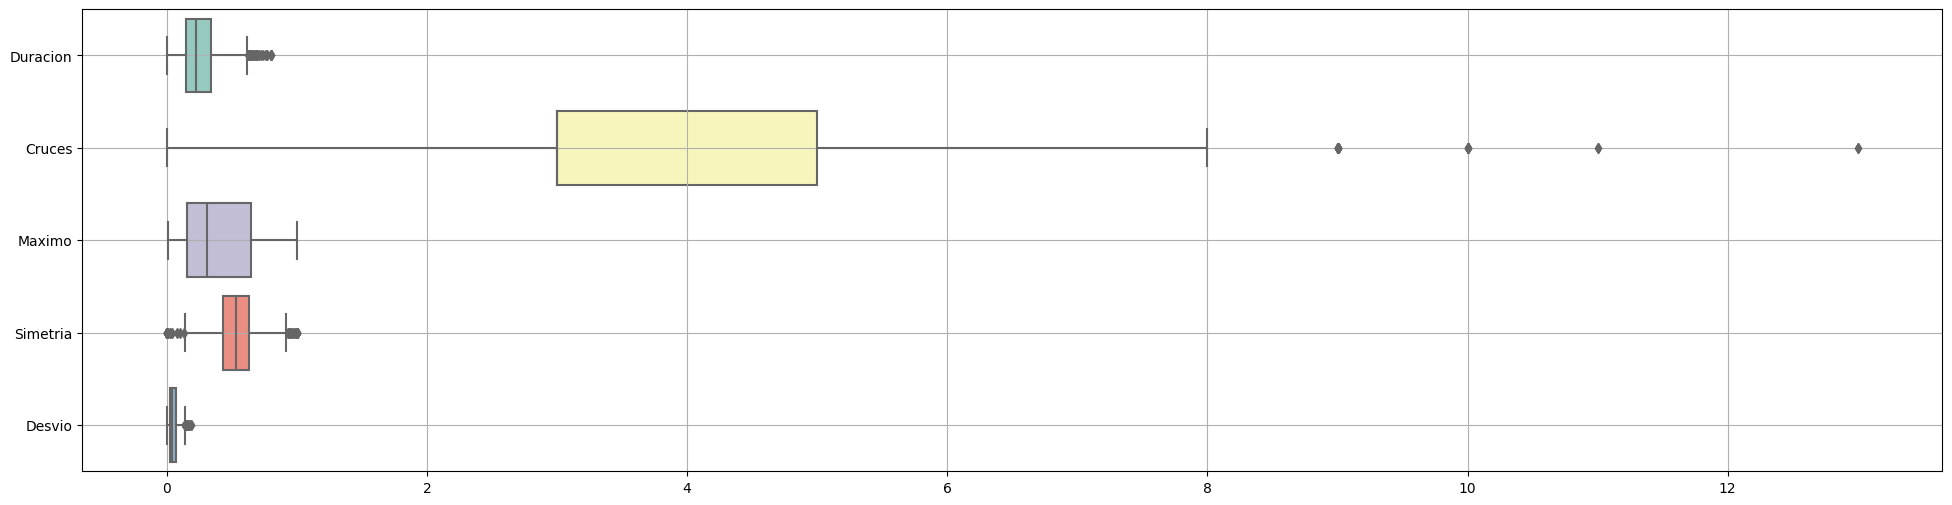

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(24,6))
seaborn.boxplot(data=df_train.iloc[:,:-1], palette="Set3", orient='h', ax=ax)
plt.grid(True)

## Profiling

**source**: https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/pages/installation.html

In [19]:
# Evita mostrar las salidas generadas en la celda
%%capture

# PROFILER AUTOMATICO

# --> EJECUTAR ESTE BLOQUE SI CORREMOS EN LA PC
#!pip install -U pandas-profiling[notebook]==2.8.0
#!jupyter nbextension enable --py widgetsnbextension


# --> EJECUTAR ESTE BLOQUE SI CORREMOS EN COLAB
import sys
!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

UsageError: Line magic function `%%capture` not found.


In [20]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df_train, title="Pandas Profiling Report")

In [21]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Manejo del desbalance

source: https://imbalanced-learn.org/stable/

In [22]:
# Genero datos para testear métodos de balanceo
X = np.array([wavdata.data for wavdata in train_dataset])
y = np.array([wavdata.label for wavdata in train_dataset])

In [23]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [24]:
from collections import Counter

items = sorted(Counter(y_resampled).items())

print(items)

[(0, 827), (1, 827), (2, 827)]


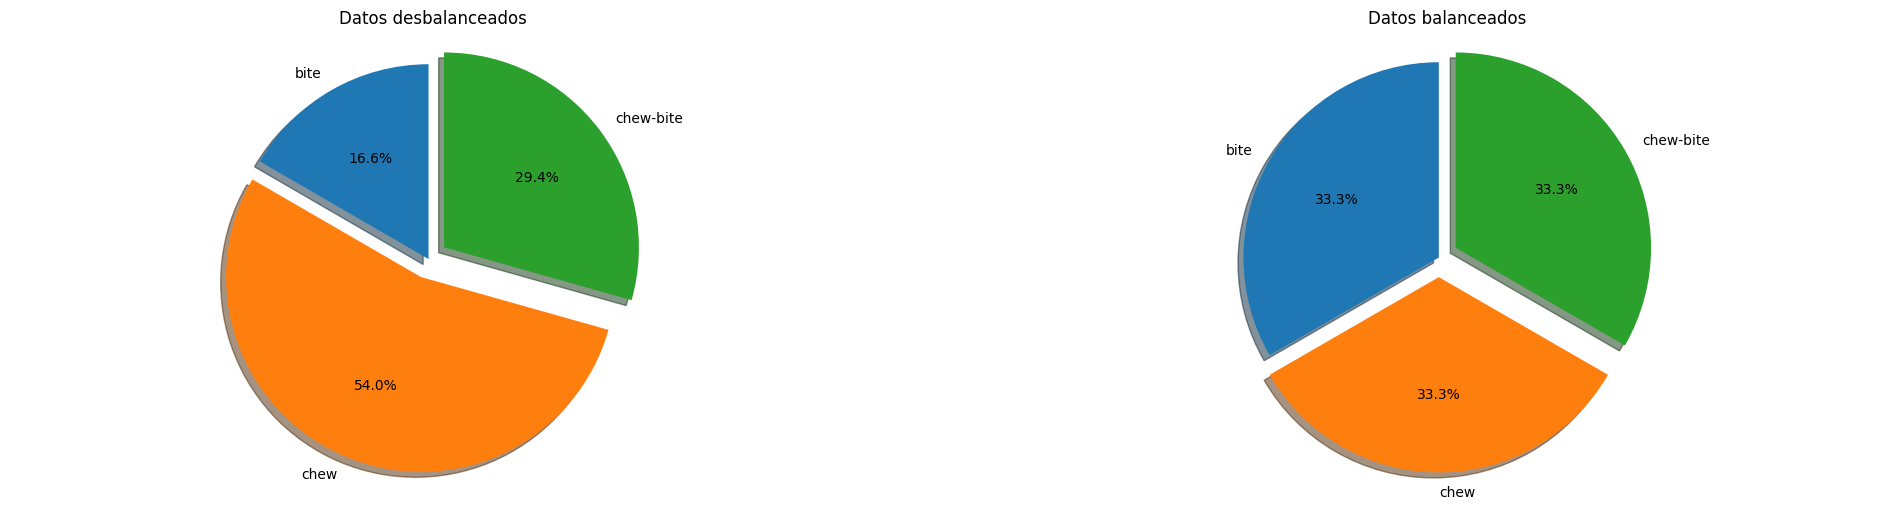

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(24,6))

ax[0].set_title('Datos desbalanceados')
ax[0].pie(n_examples,
          explode=(0, 0.1, 0.1),  # only "explode" the 2nd slice (i.e. 'Hogs'),
          labels=[eventos[l] for l in labels],
          autopct='%1.1f%%',
          shadow=True,
          startangle=90)

ax[0].axis('equal');  # Equal aspect ratio ensures that pie is drawn as a circle.

ax[1].set_title('Datos balanceados')
ax[1].pie([item[1] for item in items],
          explode=(0, 0.1, 0.1),  # only "explode" the 2nd slice (i.e. 'Hogs'),
          labels=[eventos[l] for l in labels],
          autopct='%1.1f%%',
          shadow=True,
          startangle=90)

ax[1].axis('equal');  # Equal aspect ratio ensures that pie is drawn as a circle.

# Definición y entrenamiento del clasificador

Definimos un modelo y entrenamos un clasificador al que le ingresan las características normalizadas.

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

# Clasificador con escalado de caracteristicas
model = make_pipeline(
                      StandardScaler(),
                      RandomForestClassifier(n_estimators=1, random_state=42)
                     )

model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=1, random_state=42))])

In [27]:
from sklearn.neural_network import MLPClassifier

from sklearn.tree import DecisionTreeClassifier, export_text

from sklearn import tree

### Entrenamiento y prueba única de un único modelo

In [28]:
ONLY_TREE = True

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

# Genera una nueva particion desde el conjunto de train
X_train_opt, X_optim, y_train_opt, y_optim = train_test_split(X_train,
                                                              y_train,
                                                              test_size=0.33,
                                                              random_state=42)

if ONLY_TREE:
    
    model = DecisionTreeClassifier(max_depth=2, min_samples_leaf=1, )
    
else:
    
    # Se define el modelo
    model = make_pipeline(
                          StandardScaler(),
                          DecisionTreeClassifier(max_depth=2, min_samples_leaf=1),
                          #MLPClassifier(random_state=42, max_iter=2000, early_stopping=False, n_iter_no_change=100)
                          #RandomForestClassifier(n_estimators=1, random_state=42)
                     )

# Se entrena el modelo
model.fit(X_train_opt, y_train_opt)

# Se prueba con la partición de optimización
y_pred_optim = model.predict(X_optim)

sc = balanced_accuracy_score(y_optim, y_pred_optim)
print(f"{sc:.3f} balanced accuracy")

0.705 balanced accuracy


#### Extraigo reglas, en caso de ser un árbol

In [30]:
if ONLY_TREE:
    tree_rules = export_text(model, feature_names=df_train.columns[:-1].tolist())
    print(tree_rules)

|--- Maximo <= 0.37
|   |--- Maximo <= 0.19
|   |   |--- class: 1
|   |--- Maximo >  0.19
|   |   |--- class: 1
|--- Maximo >  0.37
|   |--- Simetria <= 0.50
|   |   |--- class: 0
|   |--- Simetria >  0.50
|   |   |--- class: 2



In [42]:
# General import
import serial
import logging

# logging configuration
logging.basicConfig(level=logging.DEBUG)

# Constants
BAUDRATE = 115200
TIMEOUT = 0.25
PORT = '/dev/ttyACM0'
CHAR_START = 's'
CHAR_DEPTH = '2'
CHAR_SEPARATOR = ','
CHAR_STOP = '#'

stm32Predictions = []

# [0.34734694, 7.        , 0.39420759, 0.57450413, 0.04609246]
# s2,034,070,039,057,004#

serComm = serial.Serial(PORT, BAUDRATE, timeout=TIMEOUT)
serComm.flushInput()

for value in X_train: 

  completeTX = (CHAR_START +
                CHAR_DEPTH +
                CHAR_SEPARATOR + 
                str(int(value[0]*100)).zfill(3) +  
                CHAR_SEPARATOR + 
                str(int(value[1]*10)).zfill(3) + 
                CHAR_SEPARATOR + 
                str(int(value[2]*100)).zfill(3) + 
                CHAR_SEPARATOR + 
                str(int(value[3]*100)).zfill(3) + 
                CHAR_SEPARATOR + 
                str(int(value[4]*100)).zfill(3) +
                CHAR_STOP)

  # Loop for the iteration of each character of the completeTX message
  for i, char in enumerate(completeTX):            
      
      # Write chars to Nucleo
      serComm.write(char.encode("ascii"))    
      
  # Response readed
  charReaded = serComm.read() 

  # Char decode class received
  classRX = charReaded.decode("ascii")

  stm32Predictions.append(int(classRX))

serComm.close()

predictions = model.predict(X_train)

print(f"Equal? {np.array_equal(predictions, stm32Predictions)}")
print(f"Predictions Python: {predictions[:10].tolist()}")
print(f"Predictions STM32: {stm32Predictions[:10]}")


Equal? False
Predictions Python: [2, 2, 2, 2, 2, 2, 2, 2, 1, 2]
Predictions STM32: [2, 2, 2, 2, 2, 2, 2, 2, 1, 2]
